### Measuring the focus offsets for the MMIRS wavefront sensors

This notebook works through data taken the night of 2019/01/15 to calibrate the focus offsets between the MMIRS instrument and its two off-axis Shack-Hartmann wavefront sensors. After converging with one of the off-axis WFS's, a pair of images were taken with MMIRS in imaging mode after applying focus changes of +500 and -500 microns at M2. These out-of-focus images can then be analyzed using a curvature wavefront sensing algorithm. We use the system developed for the LSST (https://arxiv.org/abs/1506.04839) to perform the analysis. It is fully generalized and can be configured to work with any telescope/instrument. 

In [1]:
# Set up imports, data directory, and configure path to find 
import sys

import numpy as np
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import stats
from astropy.io import fits
from astropy.nddata.utils import block_reduce

from mmtwfs.wfs import *
from mmtwfs.zernike import ZernikeVector
from mmtwfs.telescope import MMT

%load_ext autoreload
%autoreload 2

sys.path.append("/Users/tim/src/cwfs/python")
%cd /Users/tim/MMT/mmirs/2019.0115/

from lsst.cwfs.instrument import Instrument
from lsst.cwfs.algorithm import Algorithm
from lsst.cwfs.image import Image, readFile
import lsst.cwfs.plots as plots

/Users/tim/MMT/mmirs/2019.0115


In [8]:
# converged with camera 1 to a focus value of 9746.73
# donuts were becoming saturated by even the midpoint of the ramp, but the 3rd readout is fine
cam1_extra_whole = fits.open("tyc3778-00232-1.5988.fits")[3].data  # focus 10246.0
cam1_intra_whole = fits.open("tyc3778-00232-1.5989.fits")[3].data  # focus 9245.18
cam1_extra = cam1_extra_whole[977-40:977+40, 994-40:994+40] - np.median(cam1_extra_whole)
cam1_intra = cam1_intra_whole[977-40:977+40, 993-40:993+40] - np.median(cam1_intra_whole)

# converved with camera 2 to a focus value of 9695.91
# no saturation even at the end of the ramp
cam2_extra_whole = fits.open("tyc3778-00232-1.5990.fits")[11].data  # focus 10195.56
cam2_intra_whole = fits.open("tyc3778-00232-1.5991.fits")[11].data  # focus 9194.82
cam2_extra = cam2_extra_whole[981-40:981+40, 992-40:992+40] - np.median(cam2_extra_whole)
cam2_intra = cam2_intra_whole[981-40:981+40, 994-40:994+40] - np.median(cam2_intra_whole)

# write out cutout images for convenience later
fits.writeto("cam1_intra.fits", cam1_intra, overwrite=True)
fits.writeto("cam1_extra.fits", cam1_extra, overwrite=True)
fits.writeto("cam2_intra.fits", cam2_intra, overwrite=True)
fits.writeto("cam2_extra.fits", cam2_extra, overwrite=True)

<IPython.core.display.Javascript object>


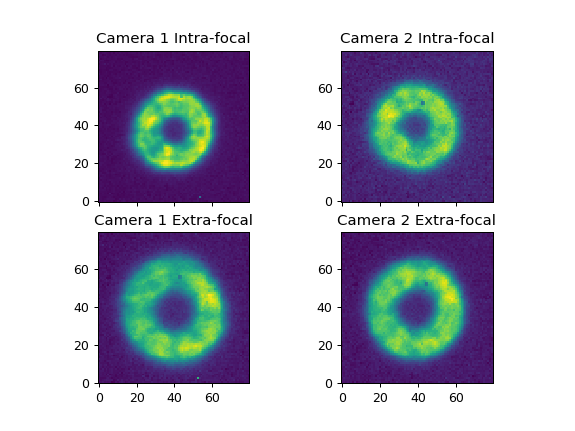

In [9]:
fig, axs = plt.subplots(2, 2, sharex=True)
axs[0, 0].imshow(cam1_intra, origin='lower')
axs[0, 0].set_title("Camera 1 Intra-focal")
axs[1, 0].imshow(cam1_extra, origin='lower')
axs[1, 0].set_title("Camera 1 Extra-focal")
axs[0, 1].imshow(cam2_intra, origin='lower')
axs[0, 1].set_title("Camera 2 Intra-focal")
axs[1, 1].imshow(cam2_extra, origin='lower')
axs[1, 1].set_title("Camera 2 Extra-focal")
plt.show()

In [10]:
# set up and configure the Instrument instance for doing the CWFS calculation
mmirs = Instrument('mmirs', cam1_intra.shape[0])   # images must be square and same size

mmirs.obscuration = 0.26                           # relative size of the central obscuration
mmirs.apertureDiameter = 6.5024                    # MMT diameter in meters
mmirs.pixelSize = 18e-6                            # MMIRS has 18 micron pixels
mmirs.focalLength = mmirs.apertureDiameter * 2.85  # effective focal length for MMIRS's f/2.85 imaging
mmirs.offset = 2.85**2 / 1.25**2 * .5e-3           # MMIRS images at f/2.85 and we used +/- 500 um focus offsets

algo = Algorithm('exp', mmirs, 3)

In [11]:
fieldXY = [0., 0.]  # assume we're on axis. haven't implemented MMT off-axis models into LSST CWFS code yet.
I1_cam1 = Image(readFile("cam1_intra.fits"), fieldXY, Image.INTRA)
I2_cam1 = Image(readFile("cam1_extra.fits"), fieldXY, Image.EXTRA)
algo.runIt(mmirs, I1_cam1, I2_cam1, 'onAxis')

resetting images: I1 and I2
imageCoCenter: (x1,y1)=(   40.25,   38.23)

imageCoCenter: (x1,y1)=(   40.45,   38.71)

itr = 0, z4-z22
[1109. -111.   31.  -36.   99.    7.  -35.  -17.  -19.  -18.  -28.    3.
    4.   -6.    9.   16.   14.   -5.  -64.]
itr = 1, z4-z22
[1261. -141.    6.  -48.  122.   24.  -27.  -21.  -20.  -19.  -28.   -3.
    6.    3.    9.   15.   11.   -0.  -26.]
itr = 2, z4-z22
[1363. -159.   -8.  -28.  110.   26.  -37.  -17.  -18.  -16.  -20.   -2.
    5.   -7.   11.   16.   10.   -5.  -12.]
itr = 3, z4-z22
[1412. -180.  -18.  -36.  117.   25.  -38.  -14.  -16.  -18.  -18.   -2.
   -5.   -3.   11.   17.    9.   -6.   -4.]
itr = 4, z4-z22
[ 1.423e+03 -1.880e+02 -3.000e+01 -3.600e+01  1.240e+02  3.200e+01
 -3.300e+01 -1.100e+01 -1.700e+01 -2.100e+01 -1.900e+01 -3.000e+00
 -0.000e+00 -1.000e+00  1.000e+01  1.700e+01  8.000e+00 -4.000e+00
  1.000e+00]
itr = 5, z4-z22
[ 1.444e+03 -2.190e+02 -3.600e+01 -3.500e+01  1.070e+02  3.000e+01
 -4.200e+01 -1.100e+01 -1.900e+01 -2.30

In [12]:
cam1_zv = ZernikeVector()
cam1_zv.from_array(algo.zer4UpNm, modestart=4, normalized=True)
cam1_zv.denormalize()
cam1_zv

Fringe Coefficients
 Z04:                  2560 nm 	 Defocus (2, 0)
 Z05:                -651.1 nm 	 Primary Astig at 45° (2, -2)
 Z06:                -192.7 nm 	 Primary Astig at 0° (2, 2)
 Z07:                -94.02 nm 	 Primary Y Coma (3, -1)
 Z08:                 267.3 nm 	 Primary X Coma (3, 1)
 Z09:                 265.5 nm 	 Y Trefoil (3, -3)
 Z10:                 -64.8 nm 	 X Trefoil (3, 3)
 Z11:                -19.57 nm 	 Primary Spherical (4, 0)
 Z12:                -69.98 nm 	 Secondary Astigmatism at 0° (4, 2)
 Z13:                -98.19 nm 	 Secondary Astigmatism at 45° (4, -2)
 Z14:                -81.45 nm 	 X Tetrafoil (4, 4)
 Z15:                -9.731 nm 	 Y Tetrafoil (4, -4)
 Z16:                 9.091 nm 	 Secondary X Coma (5, 1)
 Z17:                 -9.74 nm 	 Secondary Y Coma (5, -1)
 Z18:                  43.8 nm 	 Secondary X Trefoil (5, 3)
 Z19:                 102.6 nm 	 Secondary Y Trefoil (5, -3)
 Z20:                 52.77 nm 	 X Pentafoil (5, 5)
 Z21:    

<IPython.core.display.Javascript object>


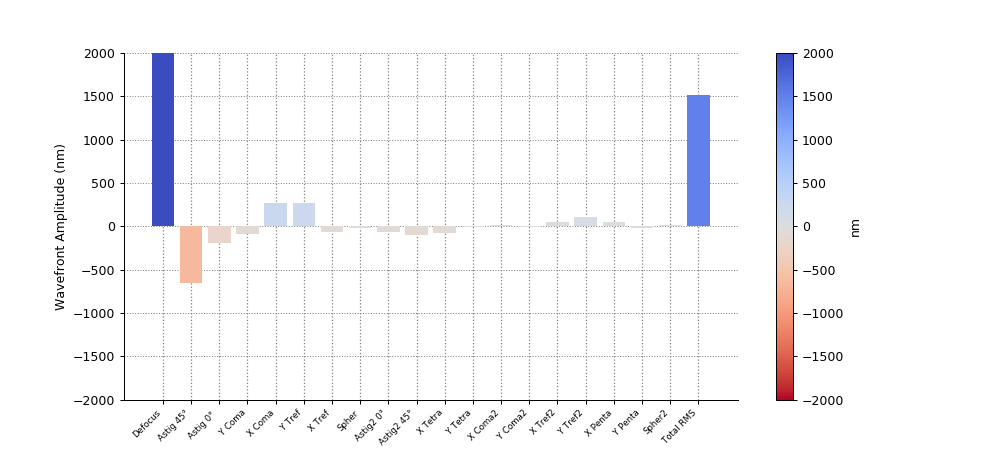

In [13]:
cam1_zv.fringe_bar_chart().show()
plt.show()

<IPython.core.display.Javascript object>


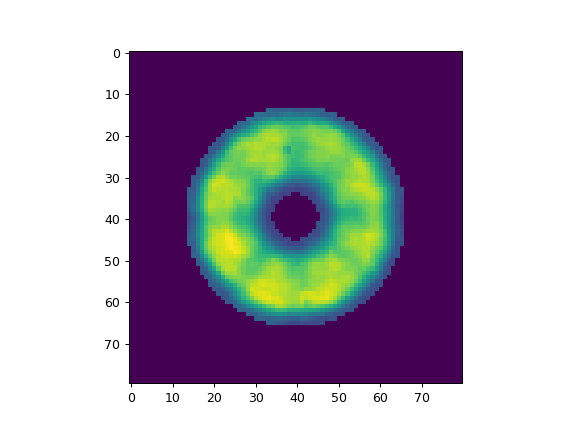

In [14]:
plt.imshow(algo.image)
plt.show()

<IPython.core.display.Javascript object>


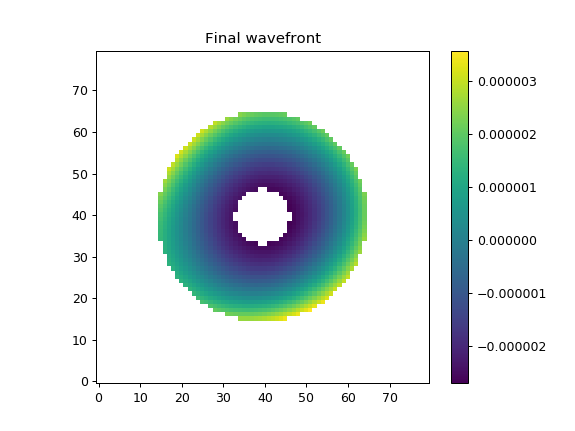

In [15]:
plots.plotImage(algo.Wconverge, "Final wavefront", show=True)

In [16]:
# set up and configure the Instrument instance for doing the CWFS calculation
#
# need to re-do everything from the start here because of state weirdness in the LSST CWFS stack...
mmirs = Instrument('mmirs', cam1_intra.shape[0])   # images must be square and same size

mmirs.obscuration = 0.26                           # relative size of the central obscuration
mmirs.apertureDiameter = 6.5024                    # MMT diameter in meters
mmirs.pixelSize = 18e-6                            # MMIRS has 18 micron pixels
mmirs.focalLength = mmirs.apertureDiameter * 2.85  # effective focal length for MMIRS's f/2.85 imaging
mmirs.offset = 2.85**2 / 1.25**2 * .5e-3           # MMIRS images at f/2.85 and we used +/- 500 um focus offsets

algo = Algorithm('exp', mmirs, 3)

In [17]:
fieldXY = [0., 0.]  # assume we're on axis. haven't implemented MMT off-axis models into LSST CWFS code yet.
I1_cam2 = Image(readFile("cam2_intra.fits"), fieldXY, Image.INTRA)
I2_cam2 = Image(readFile("cam2_extra.fits"), fieldXY, Image.EXTRA)
algo.runIt(mmirs, I1_cam2, I2_cam2, 'onAxis')

resetting images: I1 and I2
imageCoCenter: (x1,y1)=(   39.60,   39.84)

imageCoCenter: (x1,y1)=(   39.91,   39.11)

itr = 0, z4-z22
[ 671.   69. -159.   38.   34.   12.   -8. -167.   16.   -3.  -34.   -4.
   16.   -6.    7.    7.    1.   -9.   21.]
itr = 1, z4-z22
[ 787.   73. -182.   32.   50.   14.   -5. -154.   16.   -2.  -29.  -10.
    5.   -7.    7.    8.    0.   -8.   36.]
itr = 2, z4-z22
[ 847.   76. -182.   28.   54.   14.   -4. -146.   15.   -2.  -27.  -13.
    1.   -7.    7.    8.   -1.   -8.   44.]
itr = 3, z4-z22
[ 881.   91. -216.   25.   56.   13.   -5. -142.   11.   -0.  -24.  -14.
   -2.   -7.    7.    8.   -1.   -9.   48.]
itr = 4, z4-z22
[ 895.   96. -241.   24.   56.   13.   -3. -141.    8.    0.  -24.  -15.
    3.   -6.    8.    9.   -1.   -9.   50.]
itr = 5, z4-z22
[ 814.   99. -244.   25.   56.   18.   -5. -158.    8.    1.  -25.  -13.
    5.   -3.    8.    9.    0.   -8.   40.]
itr = 6, z4-z22
[ 757.  101. -235.   27.   50.   20.  -10. -167.    8.    1.  -27.  -1

In [18]:
cam2_zv = ZernikeVector()
cam2_zv.from_array(algo.zer4UpNm, modestart=4, normalized=True)
cam2_zv.denormalize()
cam2_zv

Fringe Coefficients
 Z04:                  1530 nm 	 Defocus (2, 0)
 Z05:                 270.9 nm 	 Primary Astig at 45° (2, -2)
 Z06:                -568.2 nm 	 Primary Astig at 0° (2, 2)
 Z07:                  37.5 nm 	 Primary Y Coma (3, -1)
 Z08:                 91.37 nm 	 Primary X Coma (3, 1)
 Z09:                 140.1 nm 	 Y Trefoil (3, -3)
 Z10:                 36.88 nm 	 X Trefoil (3, 3)
 Z11:                -355.8 nm 	 Primary Spherical (4, 0)
 Z12:                 36.11 nm 	 Secondary Astigmatism at 0° (4, 2)
 Z13:                     8 nm 	 Secondary Astigmatism at 45° (4, -2)
 Z14:                -154.8 nm 	 X Tetrafoil (4, 4)
 Z15:                -56.51 nm 	 Y Tetrafoil (4, -4)
 Z16:                 63.24 nm 	 Secondary X Coma (5, 1)
 Z17:                0.1286 nm 	 Secondary Y Coma (5, -1)
 Z18:                 39.59 nm 	 Secondary X Trefoil (5, 3)
 Z19:                 50.28 nm 	 Secondary Y Trefoil (5, -3)
 Z20:                 5.063 nm 	 X Pentafoil (5, 5)
 Z21:    

<IPython.core.display.Javascript object>


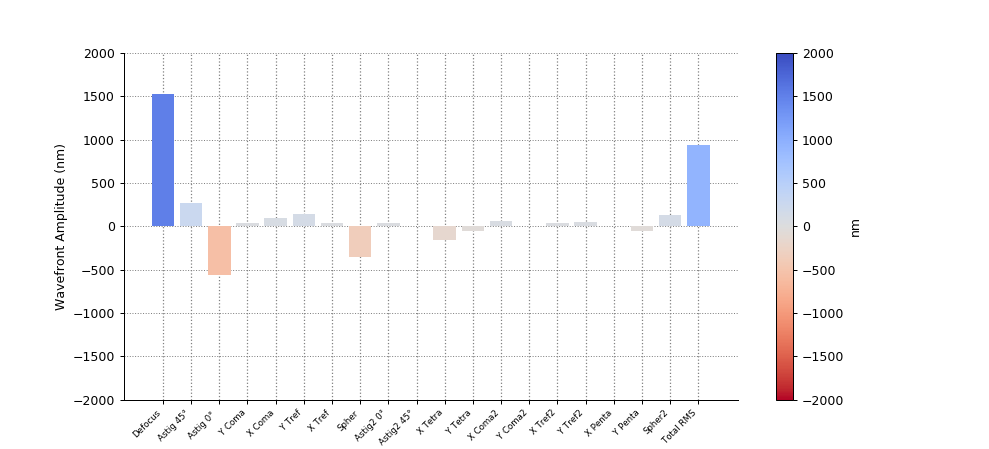

In [19]:
cam2_zv.fringe_bar_chart().show()
plt.show()

<IPython.core.display.Javascript object>


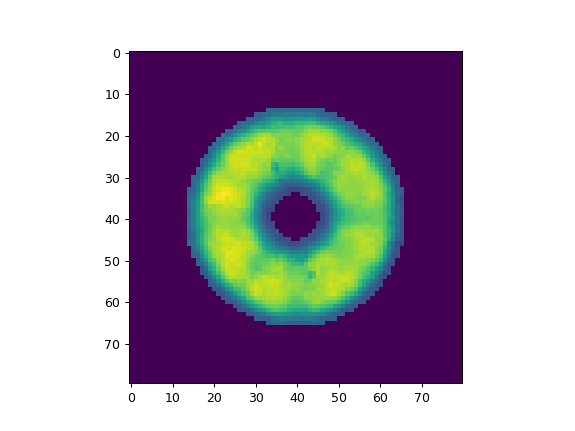

In [20]:
plt.imshow(algo.image)
plt.show()

<IPython.core.display.Javascript object>


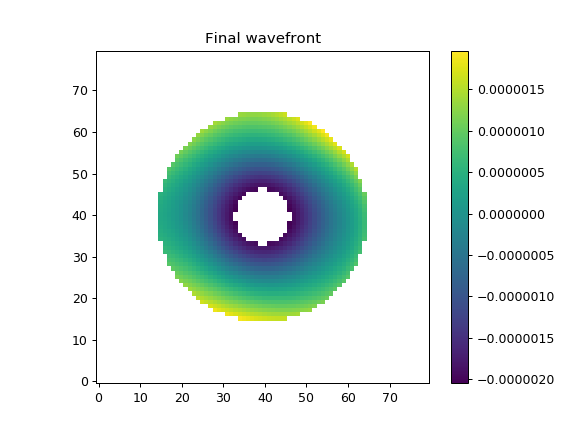

In [21]:
plots.plotImage(algo.Wconverge, "Final wavefront", show=True)

The focus offsets are quite large here. For camera 1 we get:

In [22]:
# for f/5 every micron of M2 Z motion creates 40.8 nm of wavefront defocus, Z04.
cam1_zv['Z04'].value / (40.8 / u.um)

<Quantity 62.74467731 um>

For camera 2:

In [23]:
cam2_zv['Z04'].value / (40.8 / u.um)

<Quantity 37.49428606 um>

The WFS configuration was modified based on these results and verified on-sky the night of 2019/01/17. 

In [24]:
%cd /Users/tim/MMT/mmirs/2019.0117/

/Users/tim/MMT/mmirs/2019.0117


In [25]:
# camera 1
c1_whole_extra = fits.open("HD290958.6224_dcorr.fits")[-1].data  # focus 10472.39
c1_whole_intra = fits.open("HD290958.6225_dcorr.fits")[-1].data  # focus 8473.4

# camera 2
c2_whole_extra = fits.open("HD290958.6226_dcorr.fits")[-1].data  # focus 10475.55
c2_whole_intra = fits.open("HD290958.6227_dcorr.fits")[-1].data  # focus 8477.01

x, y, size = 1008, 997, 66
c1_extra = block_reduce(c1_whole_extra[y-size:y+size, x-size:x+size] - np.median(c1_whole_extra), 2, np.median)
c1_intra = block_reduce(c1_whole_intra[y-size:y+size, x-size:x+size] - np.median(c1_whole_intra), 2, np.median)
c2_extra = block_reduce(c2_whole_extra[y-size:y+size, x-size:x+size] - np.median(c2_whole_extra), 2, np.median)
c2_intra = block_reduce(c2_whole_intra[y-size:y+size, x-size:x+size] - np.median(c2_whole_intra), 2, np.median)

# write out cutout images for convenience later
fits.writeto("cam1_intra.fits", c1_intra, overwrite=True)
fits.writeto("cam1_extra.fits", c1_extra, overwrite=True)
fits.writeto("cam2_intra.fits", c2_intra, overwrite=True)
fits.writeto("cam2_extra.fits", c2_extra, overwrite=True)

<IPython.core.display.Javascript object>


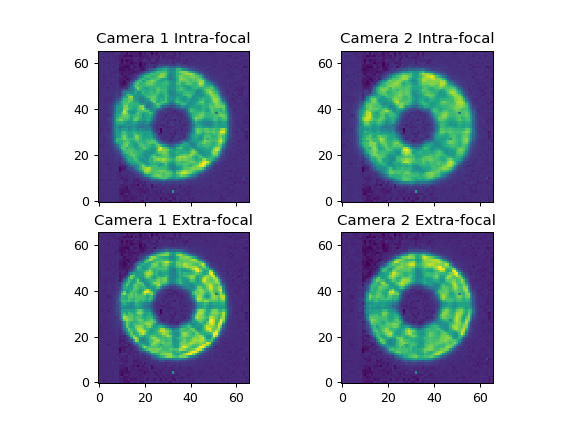

In [26]:
fig, axs = plt.subplots(2, 2, sharex=True)
axs[0, 0].imshow(c1_intra, origin='lower', norm=wfs_norm(c1_intra))
axs[0, 0].set_title("Camera 1 Intra-focal")
axs[1, 0].imshow(c1_extra, origin='lower', norm=wfs_norm(c1_extra))
axs[1, 0].set_title("Camera 1 Extra-focal")
axs[0, 1].imshow(c2_intra, origin='lower', norm=wfs_norm(c2_intra))
axs[0, 1].set_title("Camera 2 Intra-focal")
axs[1, 1].imshow(c2_extra, origin='lower', norm=wfs_norm(c2_extra))
axs[1, 1].set_title("Camera 2 Extra-focal")
plt.show()

In [27]:
# set up and configure the Instrument instance for doing the CWFS calculation
mmirs = Instrument('mmirs', c1_intra.shape[0])     # images must be square and same size

mmirs.obscuration = 0.26                           # relative size of the central obscuration
mmirs.apertureDiameter = 6.5024                    # MMT diameter in meters
mmirs.pixelSize = 2. * 18e-6                       # MMIRS has 18 micron pixels, binned 2x2 here
mmirs.focalLength = mmirs.apertureDiameter * 2.85  # effective focal length for MMIRS's f/2.85 imaging
mmirs.offset = 2.85**2 / 1.25**2 * 1.e-3           # MMIRS images at f/2.85 and we used +/- 1000 um focus offsets

algo = Algorithm('exp', mmirs, 3)

In [28]:
fieldXY = [0., 0.]  # assume we're on axis. haven't implemented MMT off-axis models into LSST CWFS code yet.
I1_cam1 = Image(readFile("cam1_intra.fits"), fieldXY, Image.INTRA)
I2_cam1 = Image(readFile("cam1_extra.fits"), fieldXY, Image.EXTRA)
algo.runIt(mmirs, I1_cam1, I2_cam1, 'onAxis')

resetting images: I1 and I2
imageCoCenter: (x1,y1)=(   32.36,   34.37)

imageCoCenter: (x1,y1)=(   33.16,   34.23)

itr = 0, z4-z22
[-395. -269. -193. -165.  331.   93.   72. -113.  -19.    1.   24.   45.
  -55.   19.   -0.    8.   45.  -13.   53.]
itr = 1, z4-z22
[-388. -276. -165. -166.  312.   98.   71. -117.  -24.    5.   33.   47.
  -39.   27.    0.   10.   47.  -12.   44.]
itr = 2, z4-z22
[-416. -286. -191. -169.  325.   93.   76. -112.  -21.   -1.   20.   48.
  -46.   32.   -1.   10.   47.  -13.   42.]
itr = 3, z4-z22
[-395. -283. -162. -166.  313.  100.   71. -120.  -27.    2.   29.   45.
  -35.   32.   -0.   10.   49.  -11.   40.]
itr = 4, z4-z22
[-423. -279. -191. -181.  326.   94.   88. -110.  -27.  -11.   16.   46.
  -46.   36.   -1.    8.   46.  -16.   43.]
itr = 5, z4-z22
[-430. -291. -215. -161.  314.   99.   81. -117.  -26.   -5.   11.   48.
  -36.   30.   -0.   11.   47.  -12.   32.]
itr = 6, z4-z22
[-432. -297. -222. -164.  314.   96.   81. -118.  -26.   -5.   12.   5

In [29]:
c1_zv = ZernikeVector()
c1_zv.from_array(algo.zer4UpNm, modestart=4, normalized=True)
c1_zv.denormalize()
c1_zv

Fringe Coefficients
 Z04:                -708.9 nm 	 Defocus (2, 0)
 Z05:                -709.5 nm 	 Primary Astig at 45° (2, -2)
 Z06:                -548.5 nm 	 Primary Astig at 0° (2, 2)
 Z07:                  -474 nm 	 Primary Y Coma (3, -1)
 Z08:                 900.1 nm 	 Primary X Coma (3, 1)
 Z09:                   272 nm 	 Y Trefoil (3, -3)
 Z10:                 208.8 nm 	 X Trefoil (3, 3)
 Z11:                -256.2 nm 	 Primary Spherical (4, 0)
 Z12:                -70.22 nm 	 Secondary Astigmatism at 0° (4, 2)
 Z13:                -13.36 nm 	 Secondary Astigmatism at 45° (4, -2)
 Z14:                 50.86 nm 	 X Tetrafoil (4, 4)
 Z15:                 152.3 nm 	 Y Tetrafoil (4, -4)
 Z16:                -152.5 nm 	 Secondary X Coma (5, 1)
 Z17:                 100.1 nm 	 Secondary Y Coma (5, -1)
 Z18:                -3.355 nm 	 Secondary X Trefoil (5, 3)
 Z19:                 49.08 nm 	 Secondary Y Trefoil (5, -3)
 Z20:                 164.5 nm 	 X Pentafoil (5, 5)
 Z21:    

<IPython.core.display.Javascript object>


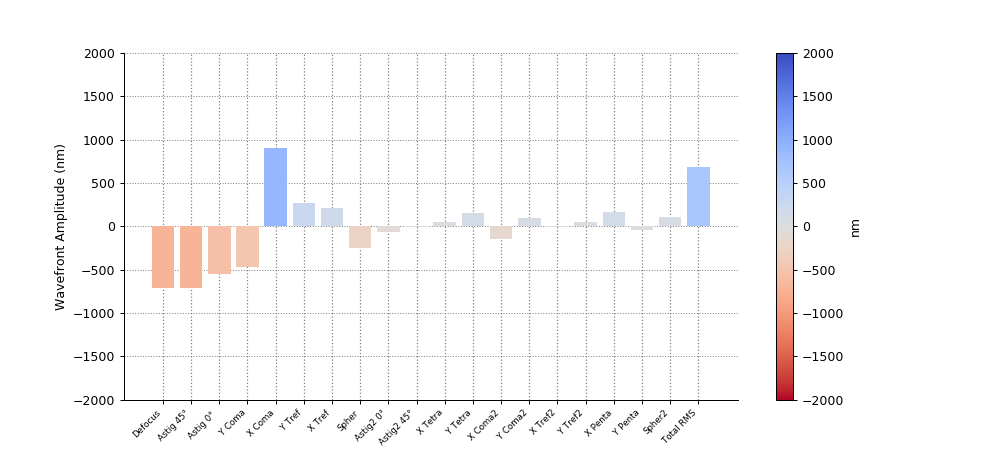

In [30]:
c1_zv.fringe_bar_chart().show()
plt.show()

<IPython.core.display.Javascript object>


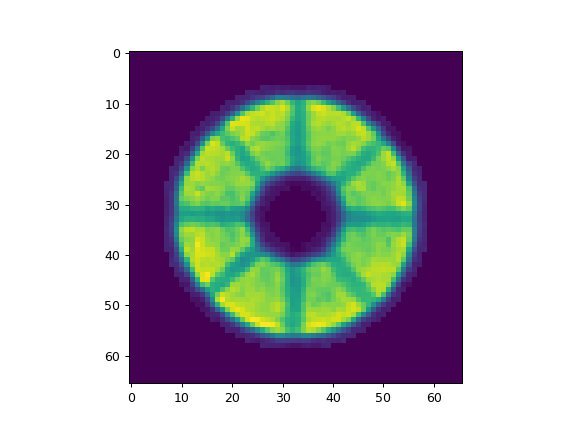

In [31]:
plt.imshow(algo.image)
plt.show()

In [32]:
# set up and configure the Instrument instance for doing the CWFS calculation
mmirs = Instrument('mmirs', c2_intra.shape[0])     # images must be square and same size

mmirs.obscuration = 0.26                           # relative size of the central obscuration
mmirs.apertureDiameter = 6.5024                    # MMT diameter in meters
mmirs.pixelSize = 2. * 18e-6                       # MMIRS has 18 micron pixels, binned 2x2 here
mmirs.focalLength = mmirs.apertureDiameter * 2.85  # effective focal length for MMIRS's f/2.85 imaging
mmirs.offset = 2.85**2 / 1.25**2 * 1.e-3           # MMIRS images at f/2.85 and we used +/- 1000 um focus offsets

algo = Algorithm('exp', mmirs, 3)

In [33]:
fieldXY = [0., 0.]  # assume we're on axis. haven't implemented MMT off-axis models into LSST CWFS code yet.
I1_cam1 = Image(readFile("cam2_intra.fits"), fieldXY, Image.INTRA)
I2_cam1 = Image(readFile("cam2_extra.fits"), fieldXY, Image.EXTRA)
algo.runIt(mmirs, I1_cam1, I2_cam1, 'onAxis')

resetting images: I1 and I2
imageCoCenter: (x1,y1)=(   33.10,   33.08)

imageCoCenter: (x1,y1)=(   34.63,   33.62)

itr = 0, z4-z22
[-355. -179. -272.   53.  237.   27.   66. -138.    9.   20.   -9.   13.
  -57.   31.    1.    9.   36.  -11.   52.]
itr = 1, z4-z22
[-366. -184. -282.   51.  236.   30.   61. -141.    9.   20.  -16.   15.
  -62.   31.    0.    9.   33.  -12.   46.]
itr = 2, z4-z22
[-393. -207. -301.   61.  240.   29.   69. -140.   17.   22.  -21.   14.
  -53.   34.    1.   11.   35.  -14.   44.]
itr = 3, z4-z22
[-399. -203. -301.   59.  239.   31.   67. -137.   11.   20.  -23.   16.
  -60.   29.   -0.   11.   32.  -14.   42.]
itr = 4, z4-z22
[-393. -196. -286.   63.  224.   35.   69. -145.    4.   23.  -15.   18.
  -46.   26.    0.   11.   36.  -15.   42.]
itr = 5, z4-z22
[-418. -214. -307.   59.  229.   32.   76. -141.   10.   18.  -30.   18.
  -54.   29.    2.   12.   32.  -15.   32.]
itr = 6, z4-z22
[-423. -210. -302.   59.  234.   30.   77. -145.    8.   19.  -31.   1

In [34]:
c2_zv = ZernikeVector()
c2_zv.from_array(algo.zer4UpNm, modestart=4, normalized=True)
c2_zv.denormalize()
c2_zv

Fringe Coefficients
 Z04:                -677.4 nm 	 Defocus (2, 0)
 Z05:                  -466 nm 	 Primary Astig at 45° (2, -2)
 Z06:                -747.5 nm 	 Primary Astig at 0° (2, 2)
 Z07:                 138.4 nm 	 Primary Y Coma (3, -1)
 Z08:                 651.1 nm 	 Primary X Coma (3, 1)
 Z09:                 100.9 nm 	 Y Trefoil (3, -3)
 Z10:                 181.2 nm 	 X Trefoil (3, 3)
 Z11:                -330.2 nm 	 Primary Spherical (4, 0)
 Z12:                 23.61 nm 	 Secondary Astigmatism at 0° (4, 2)
 Z13:                 83.17 nm 	 Secondary Astigmatism at 45° (4, -2)
 Z14:                -68.69 nm 	 X Tetrafoil (4, 4)
 Z15:                 68.29 nm 	 Y Tetrafoil (4, -4)
 Z16:                -193.1 nm 	 Secondary X Coma (5, 1)
 Z17:                 125.4 nm 	 Secondary Y Coma (5, -1)
 Z18:                 6.846 nm 	 Secondary X Trefoil (5, 3)
 Z19:                  49.8 nm 	 Secondary Y Trefoil (5, -3)
 Z20:                 123.1 nm 	 X Pentafoil (5, 5)
 Z21:    

<IPython.core.display.Javascript object>


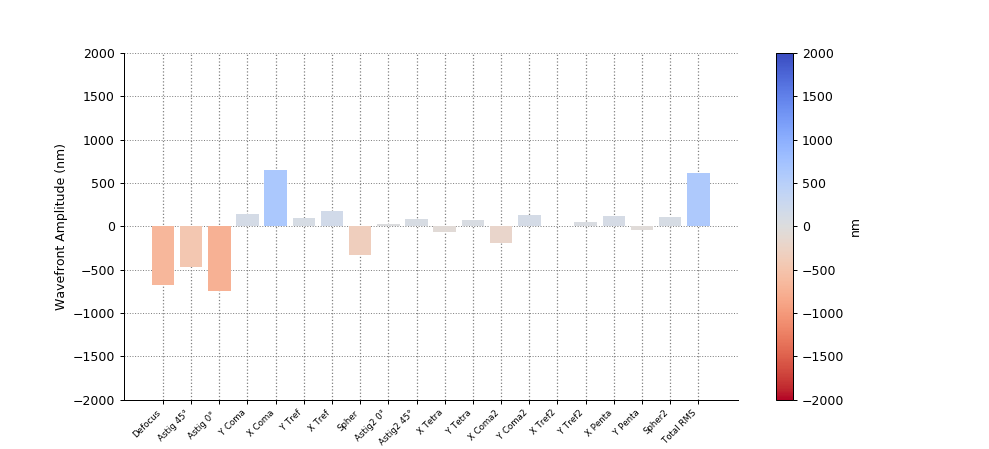

In [35]:
c2_zv.fringe_bar_chart().show()
plt.show()

In [36]:
# for f/5 every micron of M2 Z motion creates 40.8 nm of wavefront defocus, Z04.
c1_zv['Z04'].value / (40.8 / u.um)

<Quantity -17.37385076 um>

In [37]:
c2_zv['Z04'].value / (40.8 / u.um)

<Quantity -16.60233778 um>

In [38]:
382 * u.nm - c2_zv['Z04']

<Quantity 1059.37538162 nm>

In [39]:
-3885 * u.nm - c1_zv['Z04']

<Quantity -3176.14688891 nm>

<IPython.core.display.Javascript object>


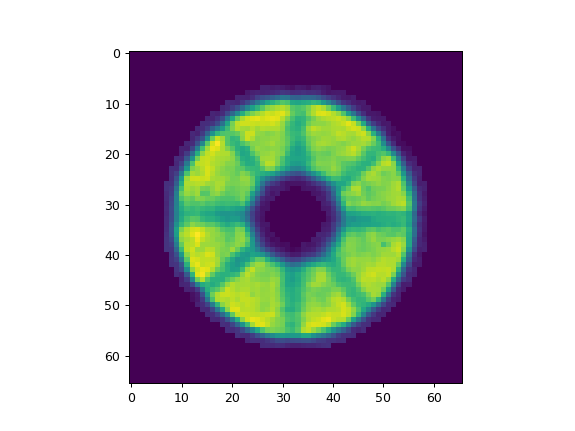

In [40]:
plt.imshow(algo.image)
plt.show()